# Student Performance Prediction

**Dataset:** [Students Performance in Exams – Kaggle](https://www.kaggle.com/datasets/spscientist/students-performance-in-exams)

In this project, I set out to predict whether a student is likely to pass or fail based on their demographic background and test preparation. I began by exploring and preprocessing the data, then trained a Decision Tree classifier as my initial model. To compare performance and gain deeper insights, I also experimented with Logistic Regression and Support Vector Machine (SVM) models. Finally, I analyzed the results and compared the models to evaluate their effectiveness.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import shutil
import zipfile

kaggle_json_path = "/content/drive/MyDrive/code/kaggle.json"

os.makedirs("/root/.kaggle", exist_ok=True)
shutil.copy(kaggle_json_path, "/root/.kaggle/kaggle.json")

os.chmod("/root/.kaggle/kaggle.json", 600)

In [3]:
!kaggle datasets download -d spscientist/students-performance-in-exams

Dataset URL: https://www.kaggle.com/datasets/spscientist/students-performance-in-exams
License(s): unknown


In [4]:
with zipfile.ZipFile("students-performance-in-exams.zip", "r") as zip_ref:
    zip_ref.extractall("students_data")

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
import warnings
warnings.filterwarnings("ignore")

# EDA

Importing dataset as pandas DataFrame

In [7]:
students = pd.read_csv("/content/students_data/StudentsPerformance.csv")

## Dataset Overview
Let's get a quick summary of the dataset to understand its size, structure, and contents.

Shape of DataFrame

In [8]:
students.shape

(1000, 8)

First and last five rows of DataFrame

In [9]:
students.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


In [10]:
students.tail()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
995,female,group E,master's degree,standard,completed,88,99,95
996,male,group C,high school,free/reduced,none,62,55,55
997,female,group C,high school,free/reduced,completed,59,71,65
998,female,group D,some college,standard,completed,68,78,77
999,female,group D,some college,free/reduced,none,77,86,86


Checking summary statistics for dataset

In [11]:
students.describe()

,math score,reading score,writing score
count,1000.00000,1000.000000,1000.000000
mean,66.08900,69.169000,68.054000
std,15.16308,14.600192,15.195657
min,0.00000,17.000000,10.000000
25%,57.00000,59.000000,57.750000
50%,66.00000,70.000000,69.000000
75%,77.00000,79.000000,79.000000
max,100.00000,100.000000,100.000000


Checking basic info

In [12]:
students.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   gender                       1000 non-null   object
 1   race/ethnicity               1000 non-null   object
 2   parental level of education  1000 non-null   object
 3   lunch                        1000 non-null   object
 4   test preparation course      1000 non-null   object
 5   math score                   1000 non-null   int64 
 6   reading score                1000 non-null   int64 
 7   writing score                1000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 62.6+ KB


Checking for null values

In [13]:
students.isna().sum()

,0
gender,0
race/ethnicity,0
parental level of education,0
lunch,0
test preparation course,0
math score,0
reading score,0
writing score,0


Number of unique values for every atribute

In [14]:
students.nunique()

,0
gender,2
race/ethnicity,5
parental level of education,6
lunch,2
test preparation course,2
math score,81
reading score,72
writing score,77


Checking class balance

In [15]:
categorical_cols = students.select_dtypes(include=['object']).columns
percentage_tables = []

for col in categorical_cols:
    proportions = students[col].value_counts(normalize=True).mul(100).round(1)
    temp_df = proportions.reset_index()
    temp_df.columns = ['category', 'percentage']
    temp_df.insert(0, 'feature', col)
    percentage_tables.append(temp_df)

summary_df = pd.concat(percentage_tables, ignore_index=True)
summary_df

,feature,category,percentage
0,gender,female,51.8
1,gender,male,48.2
2,race/ethnicity,group C,31.9
3,race/ethnicity,group D,26.2
4,race/ethnicity,group B,19.0
5,race/ethnicity,group E,14.0
6,race/ethnicity,group A,8.9
7,parental level of education,some college,22.6
8,parental level of education,associate's degree,22.2
9,parental level of education,high school,19.6


## Visualizing Features

<Axes: xlabel='math score', ylabel='Count'>

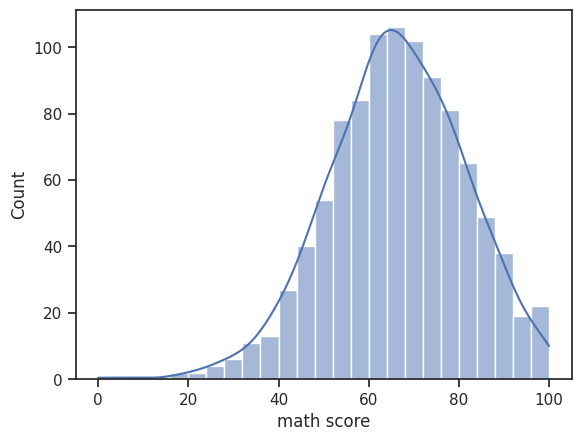

In [16]:
sns.set_theme(style="ticks")
sns.histplot(data=students, x="math score", kde=True)

<Axes: xlabel='reading score', ylabel='Count'>

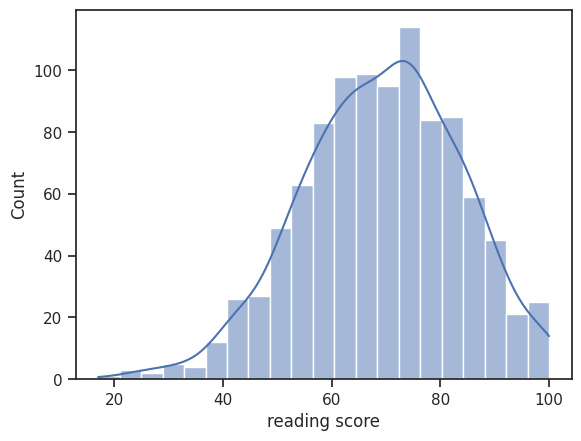

In [17]:
sns.set_theme(style="ticks")
sns.histplot(data=students, x="reading score", kde=True)

<Axes: xlabel='writing score', ylabel='Count'>

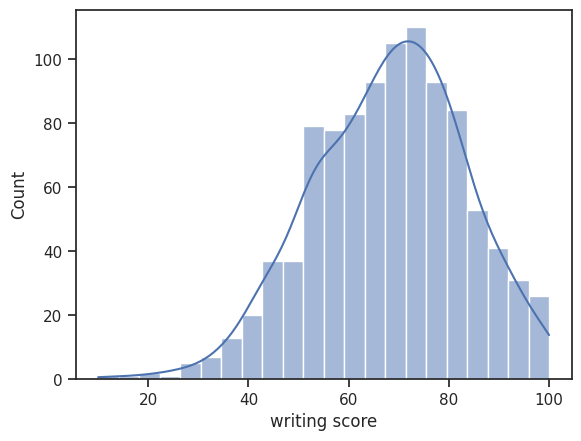

In [18]:
sns.set_theme(style="ticks")
sns.histplot(data=students, x="writing score", kde=True)

In [19]:
students['average_score'] = students[['math score', 'reading score', 'writing score']].mean(axis=1)
students['passed'] = students['average_score'] >= 50

students['passed'].value_counts(normalize=True) * 100

,proportion
passed,
True,89.7
False,10.3


In [20]:
students['passed']

,passed
0,True
1,True
2,True
3,False
4,True
...,...
995,True
996,True
997,True
998,True


In [21]:
students.rename(columns={"parental level of education": "parent_ed"}, inplace=True)
students.head()

,gender,race/ethnicity,parent_ed,lunch,test preparation course,math score,reading score,writing score,average_score,passed
0,female,group B,bachelor's degree,standard,none,72,72,74,72.666667,True
1,female,group C,some college,standard,completed,69,90,88,82.333333,True
2,female,group B,master's degree,standard,none,90,95,93,92.666667,True
3,male,group A,associate's degree,free/reduced,none,47,57,44,49.333333,False
4,male,group C,some college,standard,none,76,78,75,76.333333,True


Combination passed vs gender or passed vs preparation

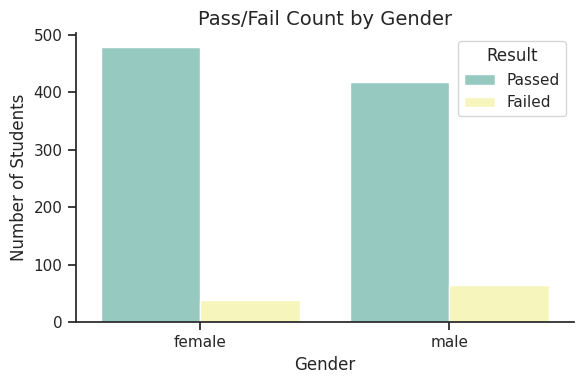

In [22]:
students['pass_label'] = students['passed'].map({True: 'Passed', False: 'Failed'})

plt.figure(figsize=(6, 4))
sns.set_theme(style="ticks")
sns.countplot(data=students, x='gender', hue='pass_label', palette="Set3")

plt.title('Pass/Fail Count by Gender', fontsize=14)
plt.xlabel('Gender')
plt.ylabel('Number of Students')
plt.legend(title='Result')

sns.despine()
plt.tight_layout()
plt.show()

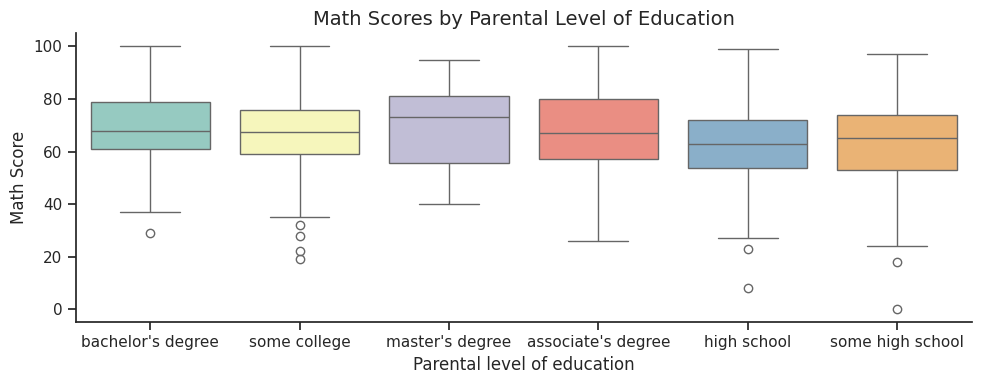

In [23]:
plt.figure(figsize=(10, 4))
sns.set_theme(style="ticks")
sns.boxplot(data=students, x="parent_ed", y="math score", palette="Set3")

plt.title('Math Scores by Parental Level of Education', fontsize=14)
plt.xlabel('Parental level of education')
plt.ylabel('Math Score')

sns.despine()
plt.tight_layout()
plt.show()

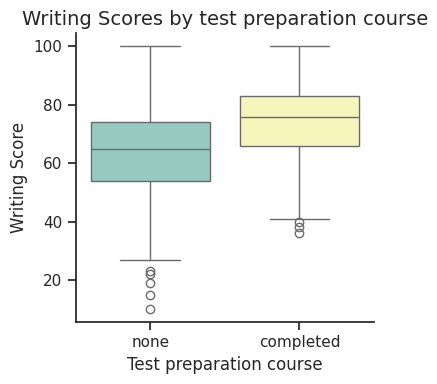

In [24]:
plt.figure(figsize=(4, 4))
sns.set_theme(style="ticks")
sns.boxplot(data=students, x="test preparation course", y="writing score", palette="Set3")

plt.title('Writing Scores by test preparation course', fontsize=14)
plt.xlabel('Test preparation course')
plt.ylabel('Writing Score')

sns.despine()
plt.tight_layout()
plt.show()

Handle categorical data for heatmap

In [25]:
students_heat = students.copy()
students_heat = students_heat.drop('pass_label', axis=1)

students_heat['gender'] = students_heat['gender'].map({'male': 0, 'female': 1})

race_map = {'group A': 0, 'group B': 1, 'group C': 2, 'group D': 3, 'group E': 4}
students_heat['race/ethnicity'] = students_heat['race/ethnicity'].map(race_map)

students_heat['lunch'] = students_heat['lunch'].map({'standard': 1, 'free/reduced': 0})
students_heat['test preparation course'] = students_heat['test preparation course'].map({'completed': 1, 'none': 0})

education_order = {
    "some high school": 0,
    "high school": 1,
    "some college": 2,
    "associate's degree": 3,
    "bachelor's degree": 4,
    "master's degree": 5
}
students_heat['parent_ed'] = students_heat['parent_ed'].map(education_order)

In [26]:
students_heat.head()

,gender,race/ethnicity,parent_ed,lunch,test preparation course,math score,reading score,writing score,average_score,passed
0,1,1,4,1,0,72,72,74,72.666667,True
1,1,2,2,1,1,69,90,88,82.333333,True
2,1,1,5,1,0,90,95,93,92.666667,True
3,0,0,3,0,0,47,57,44,49.333333,False
4,0,2,2,1,0,76,78,75,76.333333,True


Correlation matrix

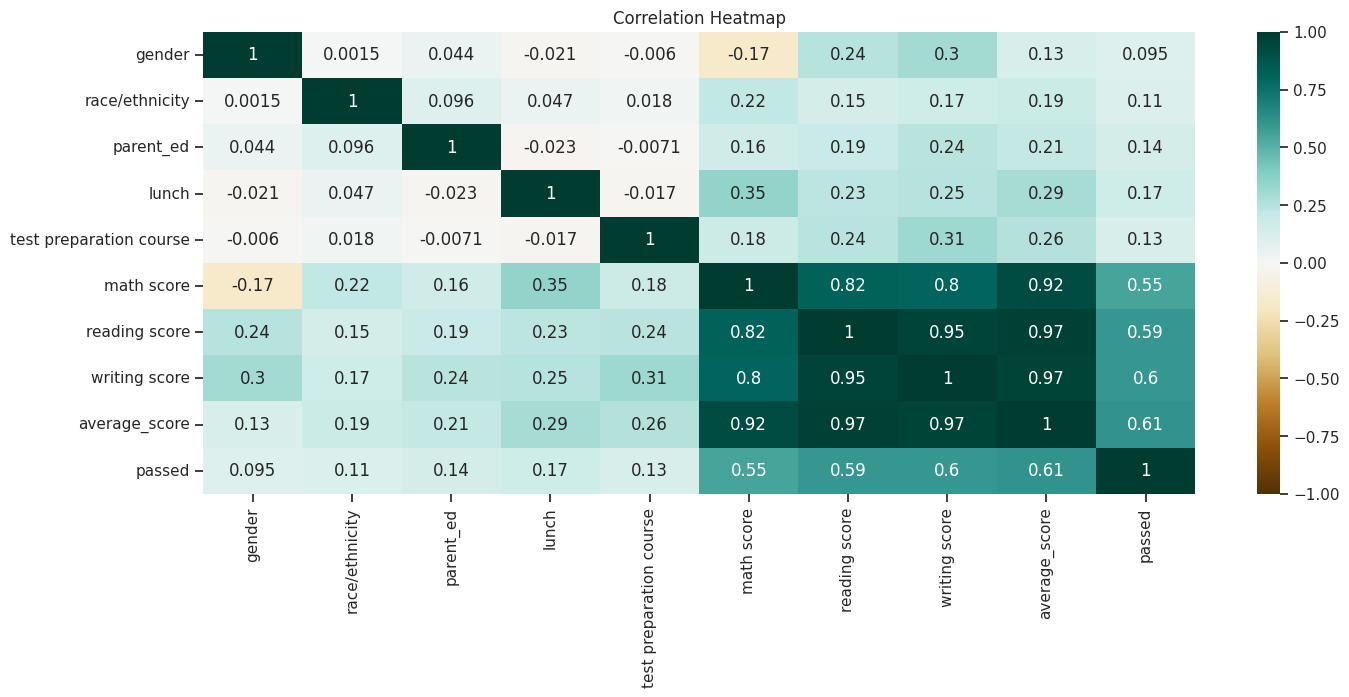

In [27]:
plt.figure(figsize=(16, 6))

heatmap = sns.heatmap(students_heat.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12})

plt.show()

Pairplot for lunch, math score and average score

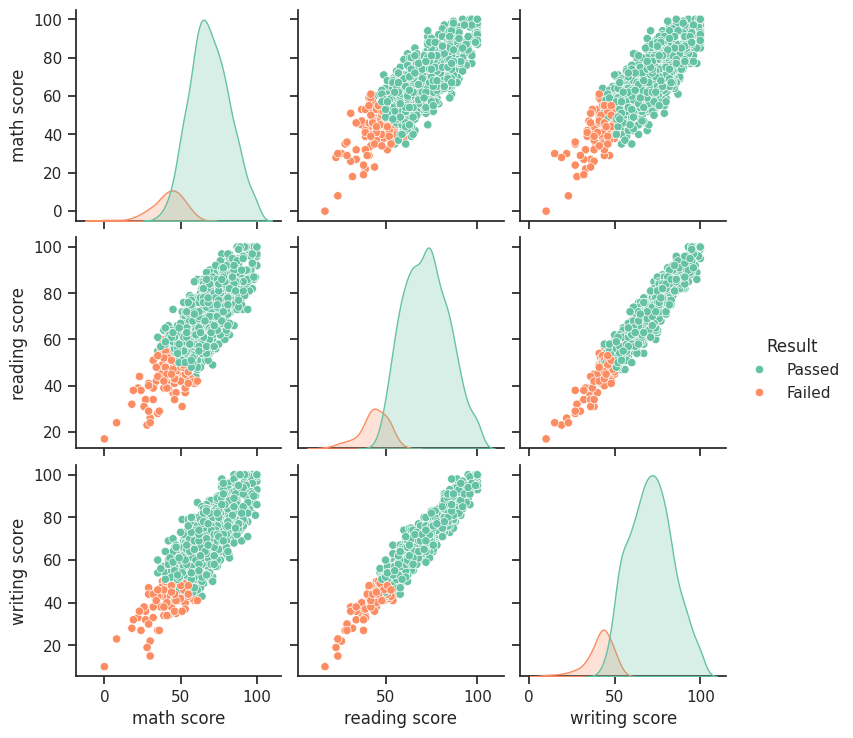

In [28]:
plot  = sns.pairplot(students, vars=['math score', 'reading score', 'writing score'], hue='pass_label', palette='Set2')
plot._legend.set_title('Result')
plt.show()

## Grouped Statistics

In [29]:
students.groupby('parent_ed')['average_score'].agg(['mean', 'count']).sort_values('mean')

,mean,count
parent_ed,,
high school,63.096939,196
some high school,65.108007,179
some college,68.476401,226
associate's degree,69.569069,222
bachelor's degree,71.923729,118
master's degree,73.598870,59


In [30]:
students.groupby('lunch')['math score'].agg(['mean', 'count']).sort_values('mean')

,mean,count
lunch,,
free/reduced,58.921127,355
standard,70.034109,645


# Data preprocessing

In [31]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

Handle categorical features

In [32]:
X = students.drop('passed', axis=1)
y = students['passed']

In [33]:
X = X.drop(columns=['pass_label','average_score'], axis=1)

In [34]:
X_num = X.select_dtypes(exclude='object')
X_cat = X.select_dtypes(include='object')

In [35]:
print(f"Categorical: {X_cat.columns}")
print(f"Numerical: {X_num.columns}")

Categorical: Index(['gender', 'race/ethnicity', 'parent_ed', 'lunch',
       'test preparation course'],
      dtype='object')
Numerical: Index(['math score', 'reading score', 'writing score'], dtype='object')


In [36]:
categorical_cols = X_cat.columns.tolist()

In [37]:
preprocessor_tree = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ],
    remainder='passthrough')

Split the data

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [39]:
final_accuracy = []
final_precision = []
final_f1_score = []
final_auc = []

# Model building

## Decision tree

In [40]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

In [41]:
tree_pipeline = Pipeline(steps=[
    ('preprocess', preprocessor_tree),
    ('model', DecisionTreeClassifier(class_weight='balanced'))
])

In [42]:
tree_pipeline.fit(X_train, y_train)

y_pred_tree = tree_pipeline.predict(X_test)
y_proba_tree = tree_pipeline.predict_proba(X_test)[:, 1]

Model evaluation

In [43]:
from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix, classification_report, RocCurveDisplay, ConfusionMatrixDisplay, roc_auc_score

In [44]:
print(classification_report(y_test, y_pred_tree))

              precision    recall  f1-score   support

       False       0.96      0.81      0.88        27
        True       0.97      0.99      0.98       173

    accuracy                           0.97       200
   macro avg       0.96      0.90      0.93       200
weighted avg       0.97      0.97      0.97       200



In [45]:
final_accuracy.append(accuracy_score(y_test, y_pred_tree))
final_precision.append(precision_score(y_test, y_pred_tree))
final_f1_score.append(f1_score(y_test, y_pred_tree))
final_auc.append(roc_auc_score(y_test, y_proba_tree))

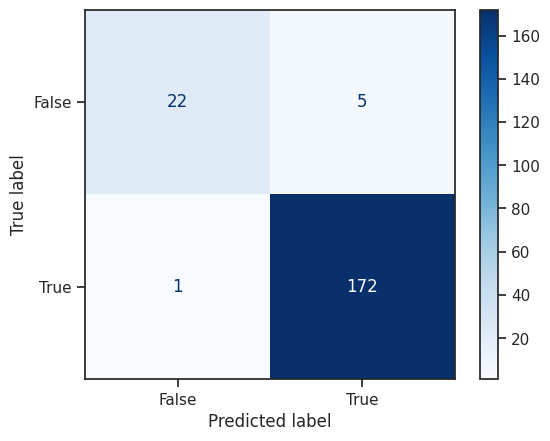

In [46]:
ConfusionMatrixDisplay.from_estimator(tree_pipeline, X_test, y_test, cmap='Blues')

## Logistic regression

In [47]:
from sklearn.linear_model import LogisticRegression

In [48]:
numerical_cols = X_num.columns.tolist()

In [49]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

In [50]:
log_pipeline = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', LogisticRegression(class_weight='balanced', max_iter=1000))
])

In [51]:
log_pipeline.fit(X_train, y_train)

y_pred_log = log_pipeline.predict(X_test)
y_proba_log = log_pipeline.predict_proba(X_test)[:, 1]

Model evaluation

In [52]:
print(classification_report(y_test, y_pred_log))

              precision    recall  f1-score   support

       False       0.90      1.00      0.95        27
        True       1.00      0.98      0.99       173

    accuracy                           0.98       200
   macro avg       0.95      0.99      0.97       200
weighted avg       0.99      0.98      0.99       200



In [53]:
final_accuracy.append(accuracy_score(y_test, y_pred_log))
final_precision.append(precision_score(y_test, y_pred_log))
final_f1_score.append(f1_score(y_test, y_pred_log))
final_auc.append(roc_auc_score(y_test, y_proba_log))

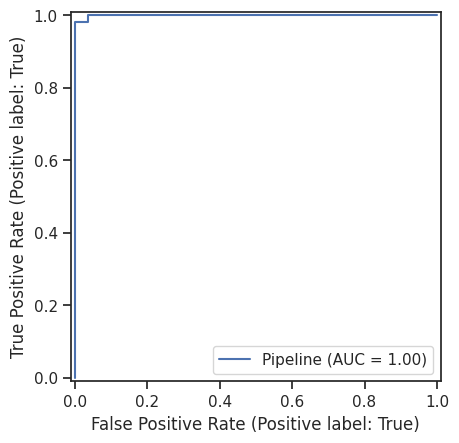

In [54]:
RocCurveDisplay.from_estimator(log_pipeline, X_test, y_test)

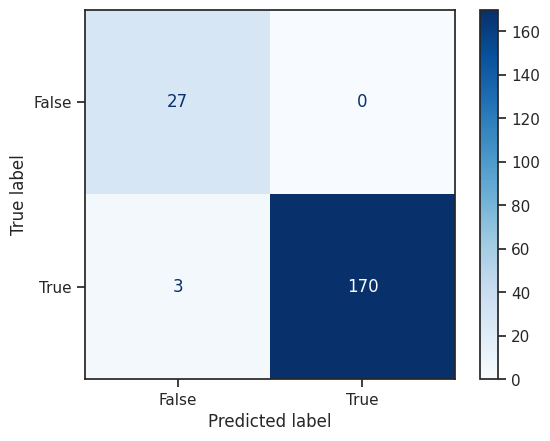

In [55]:
ConfusionMatrixDisplay.from_estimator(log_pipeline, X_test, y_test, cmap='Blues')

## Suport Vector Machine - SVM

In [56]:
from sklearn.svm import SVC

In [57]:
svm_pipeline = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', SVC(kernel='linear', C=1.0, random_state=42, class_weight='balanced', probability=True))
])

In [58]:
svm_pipeline.fit(X_train, y_train)

y_pred_svm = svm_pipeline.predict(X_test)
y_proba_svm = svm_pipeline.predict_proba(X_test)[:, 1]

Model evaluation

In [59]:
print(classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

       False       0.90      0.96      0.93        27
        True       0.99      0.98      0.99       173

    accuracy                           0.98       200
   macro avg       0.95      0.97      0.96       200
weighted avg       0.98      0.98      0.98       200



In [60]:
final_accuracy.append(accuracy_score(y_test, y_pred_svm))
final_precision.append(precision_score(y_test, y_pred_svm))
final_f1_score.append(f1_score(y_test, y_pred_svm))
final_auc.append(roc_auc_score(y_test, y_proba_svm))

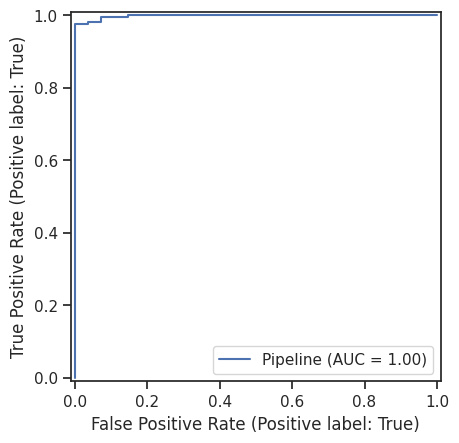

In [61]:
RocCurveDisplay.from_estimator(svm_pipeline, X_test, y_test)

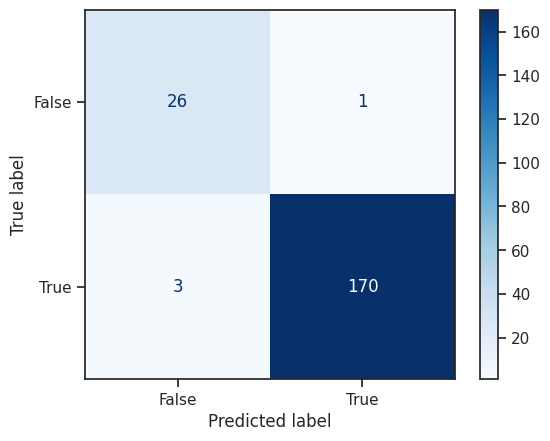

In [62]:
ConfusionMatrixDisplay.from_estimator(svm_pipeline, X_test, y_test, cmap='Blues')

# Models metrics comparison

In [63]:
model_names = ["Decision Tree", "Logistic Regression", "SVM"]

results_df = pd.DataFrame({
    "Model": model_names,
    "Accuracy": final_accuracy,
    "Precision": final_precision,
    "F1 Score": final_f1_score,
    "AUC": final_auc
})

results_melted = results_df.melt(id_vars="Model", var_name="Metric", value_name="Score")

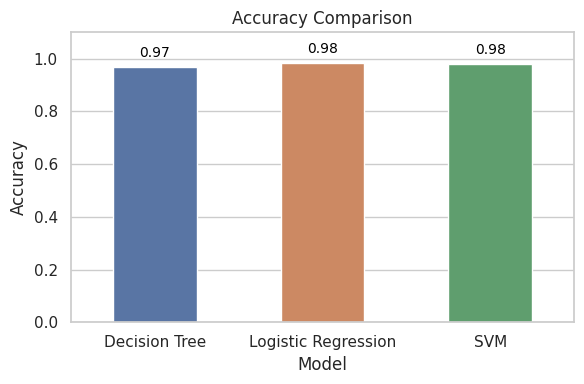

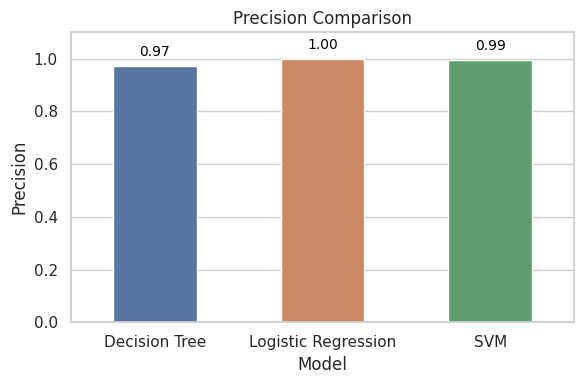

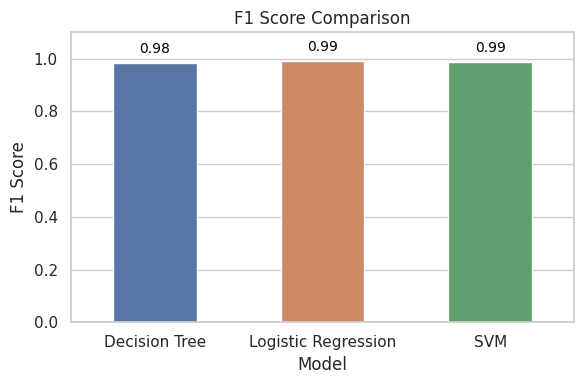

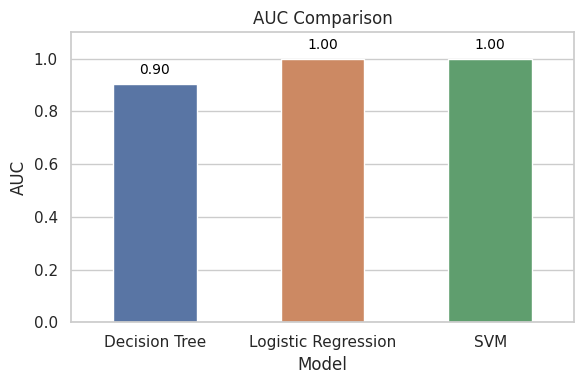

In [64]:
sns.set(style="whitegrid")

for metric in results_melted['Metric'].unique():
    plt.figure(figsize=(6, 4))
    ax = sns.barplot(data=results_melted[results_melted['Metric'] == metric],
                x='Model', y='Score', palette='deep', width=0.5)

    for container in ax.containers:
      labels = [f"{v.get_height():.2f}" for v in container]
      ax.bar_label(container, labels=labels, fontsize=10, padding=5, color='black')

    plt.title(f'{metric} Comparison')
    plt.ylim(0, 1.1)
    plt.ylabel(metric)
    plt.xlabel("Model")
    plt.tight_layout()
    plt.show()